In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt, ceil, log2

In [79]:
df = pd.read_csv("./mushrooms.csv")

In [80]:
X = df.drop(["class"], axis = 1)
y = df['class']

In [81]:
X.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,6,4,10,2,9,2,2,2,12,2,...,4,9,9,1,4,3,5,9,6,7
top,x,y,n,f,n,f,c,b,b,t,...,s,w,w,p,w,o,p,w,v,d
freq,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


In [82]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                8124 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

In [83]:
X["stalk-root"].fillna(X["stalk-root"].mode()[0], inplace=True)

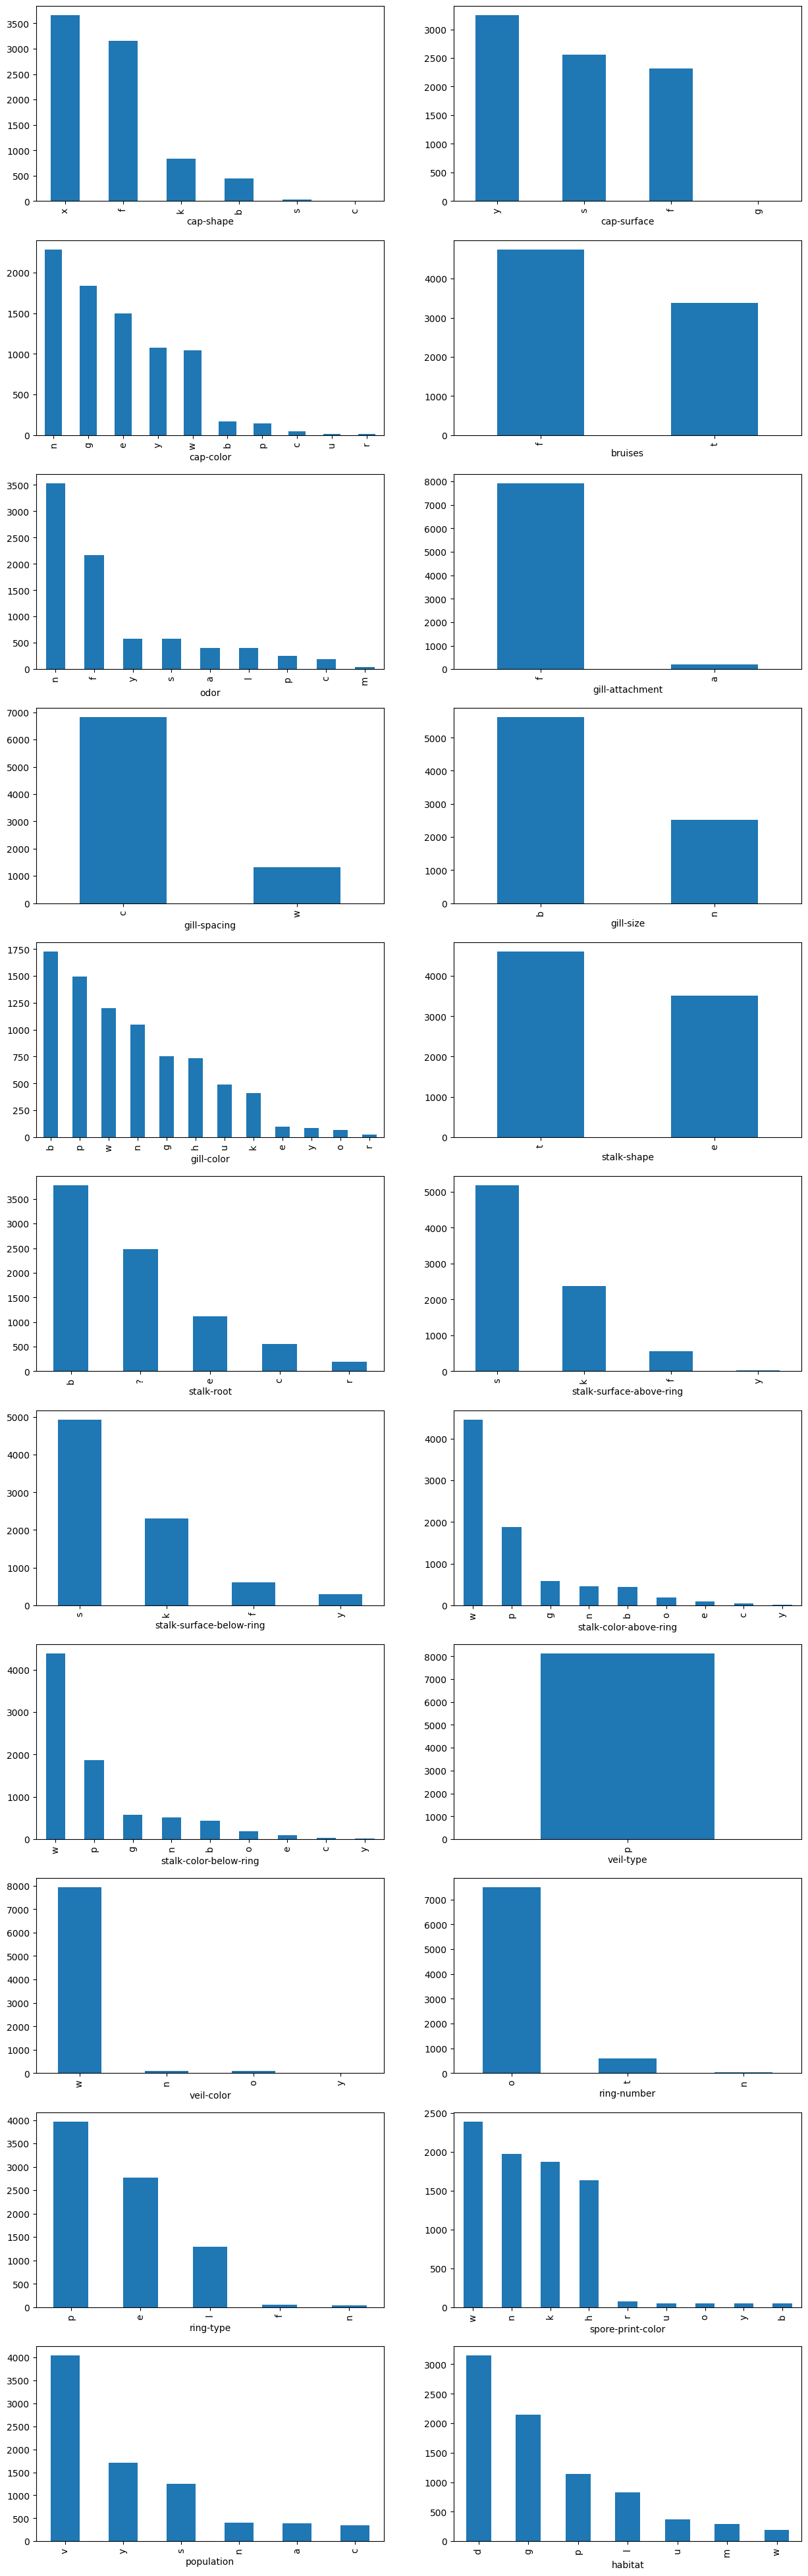

In [84]:
# fig, axs = plt.subplots(ceil(sqrt(len(X.columns))), ceil(sqrt(len(X.columns))))
fig, axs = plt.subplots(11, 2)
for ax, col in zip(axs.flatten(), X.columns):
    X[col].value_counts().plot(kind="bar", ax=ax)
fig.set_figheight(50)
fig.set_figwidth(15)

<Axes: xlabel='class'>

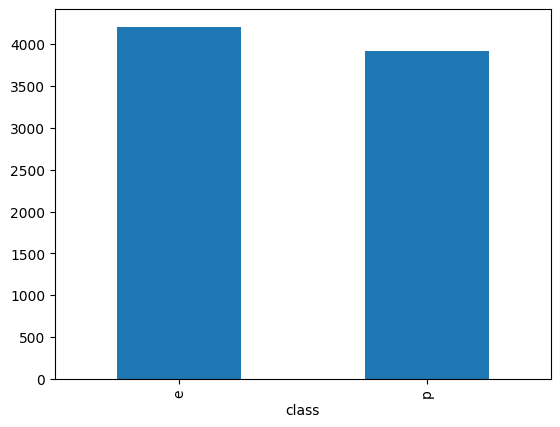

In [85]:
y.value_counts().plot(kind="bar")

In [86]:
def count_entropy(y) -> float:
    cls_names = y.unique()
    res = 0
    for cls in cls_names:
        cls_prob = y.value_counts()[cls] / len(y)
        res -= cls_prob * log2(cls_prob)
    return res

In [87]:
class Node:
    def __init__(self, feature_name, value_to_node):
        self.feature_name = feature_name
        self.value_to_node = value_to_node

    def pred(self, x):
        feature_value = x[self.feature_name]
        if feature_value not in self.value_to_node:
            return None
        return self.value_to_node[feature_value].pred(x)

    def pred_prob(self, x):
        feature_value = x[self.feature_name]
        if feature_value not in self.value_to_node:
            return 0
        return self.value_to_node[feature_value].pred_prob(x)

    def print_node(self, indent=0):
        for value, node in self.value_to_node.items():
            print(' ' * indent + f'{self.feature_name} == {value}:')
            node.print_node(indent+2)


In [88]:
class LeafNode(Node):
    def __init__(self, leaf_val, prob):
        super().__init__("", {})
        self.leaf_val = leaf_val
        self.prob = prob

    def pred(self, x):
        return self.leaf_val

    def pred_prob(self, x):
        return (self.leaf_val, self.prob)

    def print_node(self, indent=0):
        print(' ' * indent + f'-> {self.leaf_val} ({self.prob})')

In [89]:
class DecisionTree:
    def __init__(self, cols):
        self.cols = cols

    def fit(self, x, y):
        self.root = self._build_node(x[self.cols], y, count_entropy(y))

    def pred(self, x):
        res = []
        for row in x[self.cols].to_records():
            res.append(self.root.pred(row))
        return res

    def pred_prob(self, x):
        res = []
        for row in x[self.cols].to_records():
            res.append(self.root.pred_prob(row))
        return res

    def _build_node(self, x, y, parent_info):
        if len(y.unique()) == 1:
            return LeafNode(y.unique()[0], 1)

        best_gain = 0
        best_gain_info = 0
        best_gain_col = ''
        
        for col in self.cols:
            cat_names = x[col].unique()
            info = 0
            
            for cat in cat_names:
                cat_weight = x[col].value_counts()[cat] / len(x)
                entropy = count_entropy(y[x[col] == cat])
                info += cat_weight * entropy

            if parent_info - info > best_gain:
                best_gain = parent_info - info
                best_gain_info = info
                best_gain_col = col

        if best_gain_col == '':
            mode = y.mode()[0]
            return LeafNode(mode, y.value_counts()[mode] / len(y))

        values_to_node = {}

        cat_names = x[best_gain_col].unique()
        for cat in cat_names:
            values_to_node[cat] = self._build_node(x[x[best_gain_col] == cat], y[x[best_gain_col] == cat], best_gain_info)

        return Node(best_gain_col, values_to_node)

    def print_tree(self):
        self.root.print_node()


In [97]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [98]:
cols = X.columns
cols = np.random.choice(cols, ceil(sqrt(len(cols))))

print("Используются признаки:", *cols)

tree = DecisionTree(cols)
tree.fit(X_train, y_train)
tree.print_tree()

Используются признаки: ring-number bruises habitat gill-spacing stalk-shape
bruises == f:
  gill-spacing == w:
    habitat == g:
      -> e (1)
    habitat == d:
      -> p (1)
    habitat == l:
      -> e (0.851063829787234)
  gill-spacing == c:
    habitat == l:
      stalk-shape == t:
        -> p (1)
      stalk-shape == e:
        -> e (1)
    habitat == g:
      -> p (1)
    habitat == d:
      stalk-shape == e:
        -> p (0.9119373776908023)
      stalk-shape == t:
        -> p (1)
    habitat == u:
      -> e (1)
    habitat == p:
      ring-number == o:
        -> p (1)
      ring-number == t:
        -> e (1)
bruises == t:
  habitat == m:
    ring-number == o:
      -> e (1)
    ring-number == t:
      -> p (1)
  habitat == d:
    -> e (1)
  habitat == u:
    -> p (1)
  habitat == g:
    -> e (0.527831094049904)
  habitat == w:
    -> e (1)
  habitat == p:
    -> e (1)
  habitat == l:
    -> p (1)


In [99]:
def confusion_matrix(pred_y, true_y):
    res = np.zeros((2, 2))

    for pred, true in zip(pred_y, true_y):
        pred = 1 if pred == 'e' else 0
        true = 1 if true == 'e' else 0
        res[pred][true] += 1
    
    return res

def confusion_matrix_prob(pred_probs, true_y, threshold):
    res = np.zeros((2, 2))

    for pred_prob, true in zip(pred_probs, true_y):
        pred = 1 if pred_prob >= threshold else 0
        true = 1 if true == 'e' else 0
        res[pred][true] += 1

    return res

def accuracy(conf):
    return (conf[1][1] + conf[0][0]) / sum(conf.flatten())

def precision(conf):
    return conf[1][1] / (conf[1][1] + conf[1][0])

def recall(conf):
    return conf[1][1] / (conf[1][1] + conf[0][1])

def fallout(conf):
    return conf[1][0] / (conf[1][0] + conf[0][0])

In [100]:
pred_y = tree.pred(X_test)
conf = confusion_matrix(pred_y, y_test)
print(conf)
print('Accuracy:', accuracy(conf))
print('Precision', precision(conf))
print('Recall:', recall(conf))

[[710.  11.]
 [ 63. 841.]]
Accuracy: 0.9544615384615385
Precision 0.9303097345132744
Recall: 0.9870892018779343


In [101]:
pred_prob = tree.pred_prob(X_test)
probs = []

for i in range(len(pred_prob)):
    pred, prob = pred_prob[i]
    if pred == 'e':
        probs.append(prob)
    else:
        probs.append(1-prob)

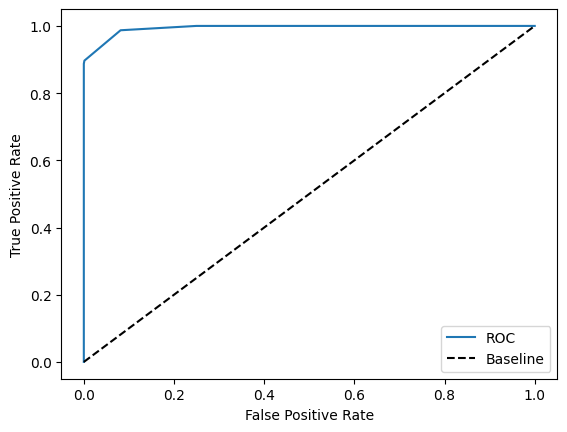

In [102]:
tpr = []
fpr = []

for th in np.arange(1, 0, -0.01):
    conf = confusion_matrix_prob(probs, y_test, th)
    tpr.append(recall(conf))
    fpr.append(fallout(conf))

plt.plot([0] + fpr + [1], [0] + tpr + [1], label='ROC')
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), 'k--', label='Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

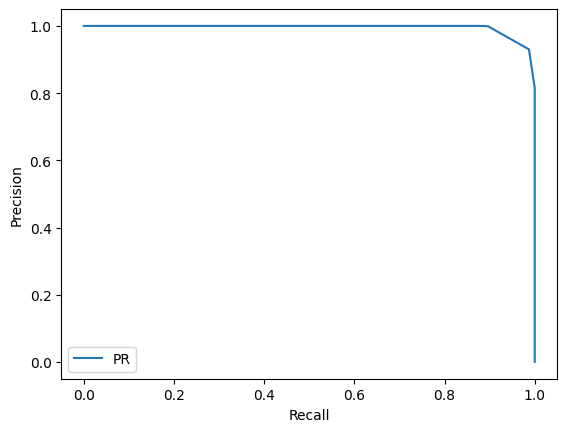

In [103]:
p = []
r = []

for th in np.arange(0, 1, 0.01):
    conf = confusion_matrix_prob(probs, y_test, th)
    p.append(precision(conf))
    r.append(recall(conf))

plt.plot([1] + r + [0], [0] + p + [1], label='PR')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()